In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split

D:\ana\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
df_train = pd.read_csv("cs-training.csv",index_col=0)
# Fill-in the missing values (nan) with the column means
df_train.fillna(df_train.mean(),inplace=True)

In [3]:
# Divide the dataset into train set and test set

X, y = df_train.iloc[:, 1:].values, df_train.iloc[:, 0].values

X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Bringing features onto the same scale

sc = StandardScaler()
sc.fit(X_train) 
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test) 

# Extract a few (>2) features using PCA method

According to the cumulative explained variance plot, choose the first 6 features which can explain variance above 80%

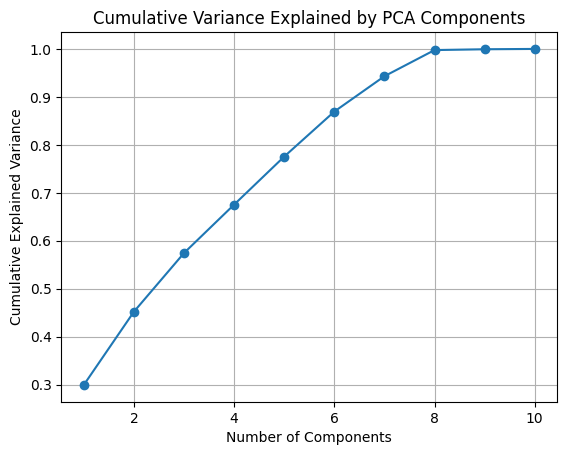

In [4]:
pca = PCA()
pca.fit(X_train_std)
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Variance Explained by PCA Components')
plt.grid(True)
plt.show()

# Apply LR / SVM / Decision Tree

In [5]:
def train_model(pipe_model, param_grid, model_name):
    """
    To get best model with best hyperparameters under features selected by PCA method
    Return probabilities of y=1 to plot ROC curve
    """
    gs = GridSearchCV(estimator=pipe_model, 
                      param_grid=param_grid, 
                      scoring='accuracy', 
                      refit=True, 
                      cv=5,
                      n_jobs=-1)
    gs = gs.fit(X_train, y_train)
    print("Model: " + model_name)
    print("Train accuarcy: %.3f" % gs.best_score_) 
    print("Best hyperparameters: ", gs.best_params_)
    clf = gs.best_estimator_
    print("Test accuracy: %.3f" % clf.score(X_test, y_test))
    print("-------------------")
    return clf.predict_proba(X_test)[:, 1]

In [10]:
num_feature = 6

# Logistic Regression
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=num_feature),
                        LogisticRegression(random_state=1, solver='lbfgs'))
param_lr = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100]}

# SVM: linear and non_linear
pipe_svc_linear = make_pipeline(StandardScaler(),
                                PCA(n_components=num_feature),
                                SVC(random_state=1,kernel='linear',probability=True))
param_svc_linear = {'svc__C': [0.1, 1.0, 10.0]}
    
pipe_svc_rbf = make_pipeline(StandardScaler(),
                             PCA(n_components=num_feature),
                             SVC(random_state=1,kernel='rbf',probability=True))
param_svc_rbf = {'svc__C': [0.1, 1.0, 10.0], 'svc__gamma': [0.1, 1.0, 10.0]}
               
# Decision Tree
pipe_dt = make_pipeline(StandardScaler(),
                        PCA(n_components=num_feature),
                        DecisionTreeClassifier(random_state=1))
param_dt = {'decisiontreeclassifier__max_depth': [1, 2, 3, 4, 5], 'decisiontreeclassifier__min_samples_split': [2, 3, 4, 5], 'decisiontreeclassifier__min_samples_leaf': [1, 2, 3, 4, 5]}

In [7]:
pipe_models = [pipe_lr, pipe_dt]
params = [param_lr, param_dt]
model_names = ["Logistic Regression","Decision Tree"]

In [8]:
predictions = []
for model,param,name in zip(pipe_models, params, model_names):
    y_prob = train_model(model, param, name)
    predictions.append(y_prob)

Model: Logistic Regression
Train accuarcy: 0.933
Best hyperparameters:  {'logisticregression__C': 0.001}
Test accuracy: 0.933
-------------------
Model: Decision Tree
Train accuarcy: 0.936
Best hyperparameters:  {'decisiontreeclassifier__max_depth': 4, 'decisiontreeclassifier__min_samples_leaf': 1, 'decisiontreeclassifier__min_samples_split': 2}
Test accuracy: 0.936
-------------------


In [9]:
# SVC_rbf
# I forgot to set "probability=True" when setting "make_pipeline", so an error occurred
# But I already know the optimal parameters, so I can directly set the model below
predictions.append(train_model(pipe_svc_rbf, param_svc_rbf, "SVC_rbf"))

Model: SVC_rbf
Train accuarcy: 0.936
Best hyperparameters:  {'svc__C': 10.0, 'svc__gamma': 1.0}
Test accuracy: 0.936
-------------------


AttributeError: predict_proba is not available when  probability=False

In [11]:
best_svc_rbf = make_pipeline(StandardScaler(),
                             PCA(n_components=num_feature),
                             SVC(C=10,gamma=1,random_state=1,kernel='rbf',probability=True))
best_svc_rbf.fit(X_train, y_train)
predictions.append(best_svc_rbf.predict_proba(X_test)[:, 1])

In [14]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier
pipe_rf = make_pipeline(StandardScaler(),
                        PCA(n_components=num_feature),
                        RandomForestClassifier(random_state=1))
param_rf = {
    'randomforestclassifier__n_estimators': [5, 8, 10],
    'randomforestclassifier__max_depth': [None, 5, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10]
}
predictions.append(train_model(pipe_rf, param_rf, "Random Forest"))

Model: Random Forest
Train accuarcy: 0.936
Best hyperparameters:  {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__min_samples_split': 5, 'randomforestclassifier__n_estimators': 10}
Test accuracy: 0.935
-------------------


In [16]:
# predictions.append(train_model(pipe_svc_linear, param_svc_linear, "SVC_linear"))
# difficlut to run out the best hyperparameters because training 1 hyperparameter needs a long time
# so I just choose C = 1 to print the final comparision result
best_svc_linear = make_pipeline(StandardScaler(),
                             PCA(n_components=num_feature),
                             SVC(C=1,random_state=1,kernel='linear',probability=True))
best_svc_linear.fit(X_train, y_train)
predictions.append(best_svc_linear.predict_proba(X_test)[:, 1])

# Compare different models by ROC curve 

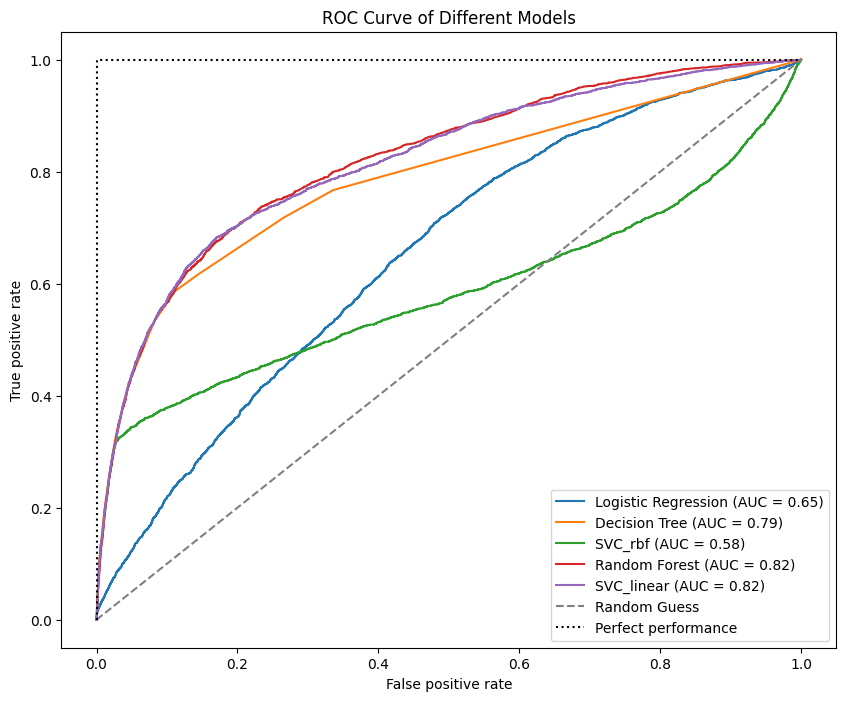

In [17]:
model_names = ["Logistic Regression","Decision Tree","SVC_rbf","Random Forest","SVC_linear"]

plt.figure(figsize=(10, 8))


for i in range(len(predictions)):
    
    fpr, tpr, _ = roc_curve(y_test, predictions[i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{model_names[i]} (AUC = {roc_auc:.2f})')

# Draw the ROC curve of a random guessing model
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')

# Draw the ROC curve of the perfet model
plt.plot([0, 0, 1],
         [0, 1, 1],
         linestyle=':',
         color='black',
         label='Perfect performance')

# Add titles and labels
plt.title('ROC Curve of Different Models')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc="lower right")

# Show Legend 
plt.legend()

plt.show()